In [61]:
#!g1.1
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import nutpie
import pymc as pm
import scipy.special as sp
import scipy.stats as st
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/pytensor/link/c/exceptions.py:13: UserWarning: You appear to be using an ancient version of setuptools: v51.0.0. Please upgrade to at least v59.0.0. Support for this version of setuptools is provisionary and may be removed without warning in the future.
  warnings.warn(
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [62]:
#!g1.1
housing = fetch_california_housing(as_frame=True)

In [63]:
#!g1.1
data = housing["data"].copy()
target = housing["target"]
non_negative_variables = [
    "MedInc",
    "HouseAge",
    "AveRooms",
    "AveBedrms",
    "Population",
    "AveOccup",
]
data[non_negative_variables] = np.log1p(data[non_negative_variables])
target = np.log(target)

In [64]:
#!g1.1
Xscaler = StandardScaler()
Yscaler = StandardScaler()
X = Xscaler.fit_transform(data)
Y = Xscaler.fit_transform(target.values[:, None])[:, 0]
X = np.concatenate([X, np.random.randn(X.shape[0], 10)], axis=-1)

# R2

Кажется 0.6-0.8

# Importance

In [65]:
#!g1.1
X.shape, Y.shape

((20640, 18), (20640,))

In [66]:
#!g1.1
data.columns.size

8

In [ ]:
#!g1.1
Xinputed = pm.Normal("X", 0, 1, observed=X)

In [40]:
#!g1.1
with pm.Model(coords=dict(
    variable=[*data.columns, *map(str, range(10))], 
    observation=range(X.shape[0])
)) as model:
    # common 
    intercept = pm.Normal("intercept", 0, 0.05)
    σ = pm.LogNormal("σ", 0, 0.05)
    # variable and regression
    R2 = pm.Beta("R2", mu=0.6, sigma=0.2)
    ϕ = pm.Dirichlet("ϕ", [1]*8+[1]*10, dims="variable")
    
    model_σ = σ * R2 ** .5
    resid_σ = σ * (1 - R2) ** .5
    
    β = pm.Normal("β", 0, model_σ * ϕ ** .5, dims="variable")
    
    μ = intercept + X @ β
    
    pm.Normal("obs", μ, resid_σ, dims="observation", observed=Y)

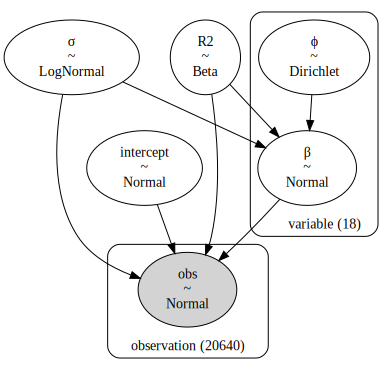

In [41]:
#!g1.1
pm.model_to_graphviz(model)

In [42]:
#!g1.1
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, σ, R2, ϕ, β]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 442 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


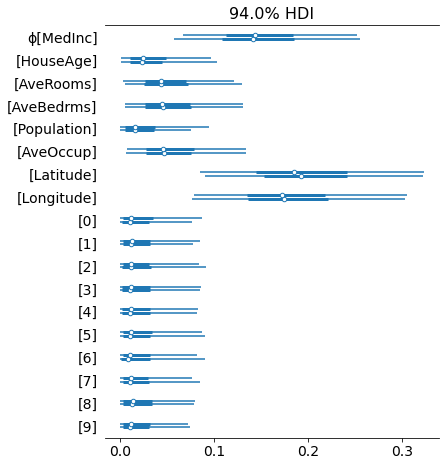

In [43]:
#!g1.1
az.plot_forest(trace, var_names=["ϕ"]);

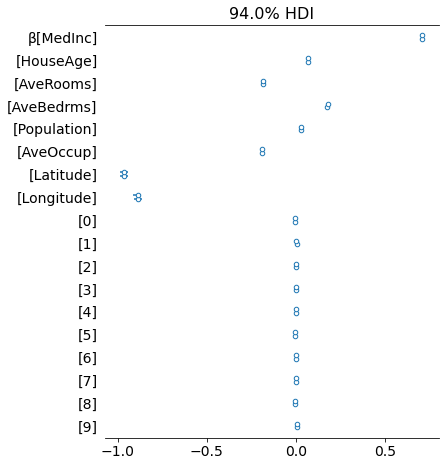

In [44]:
#!g1.1
az.plot_forest(trace, var_names=["β"]);

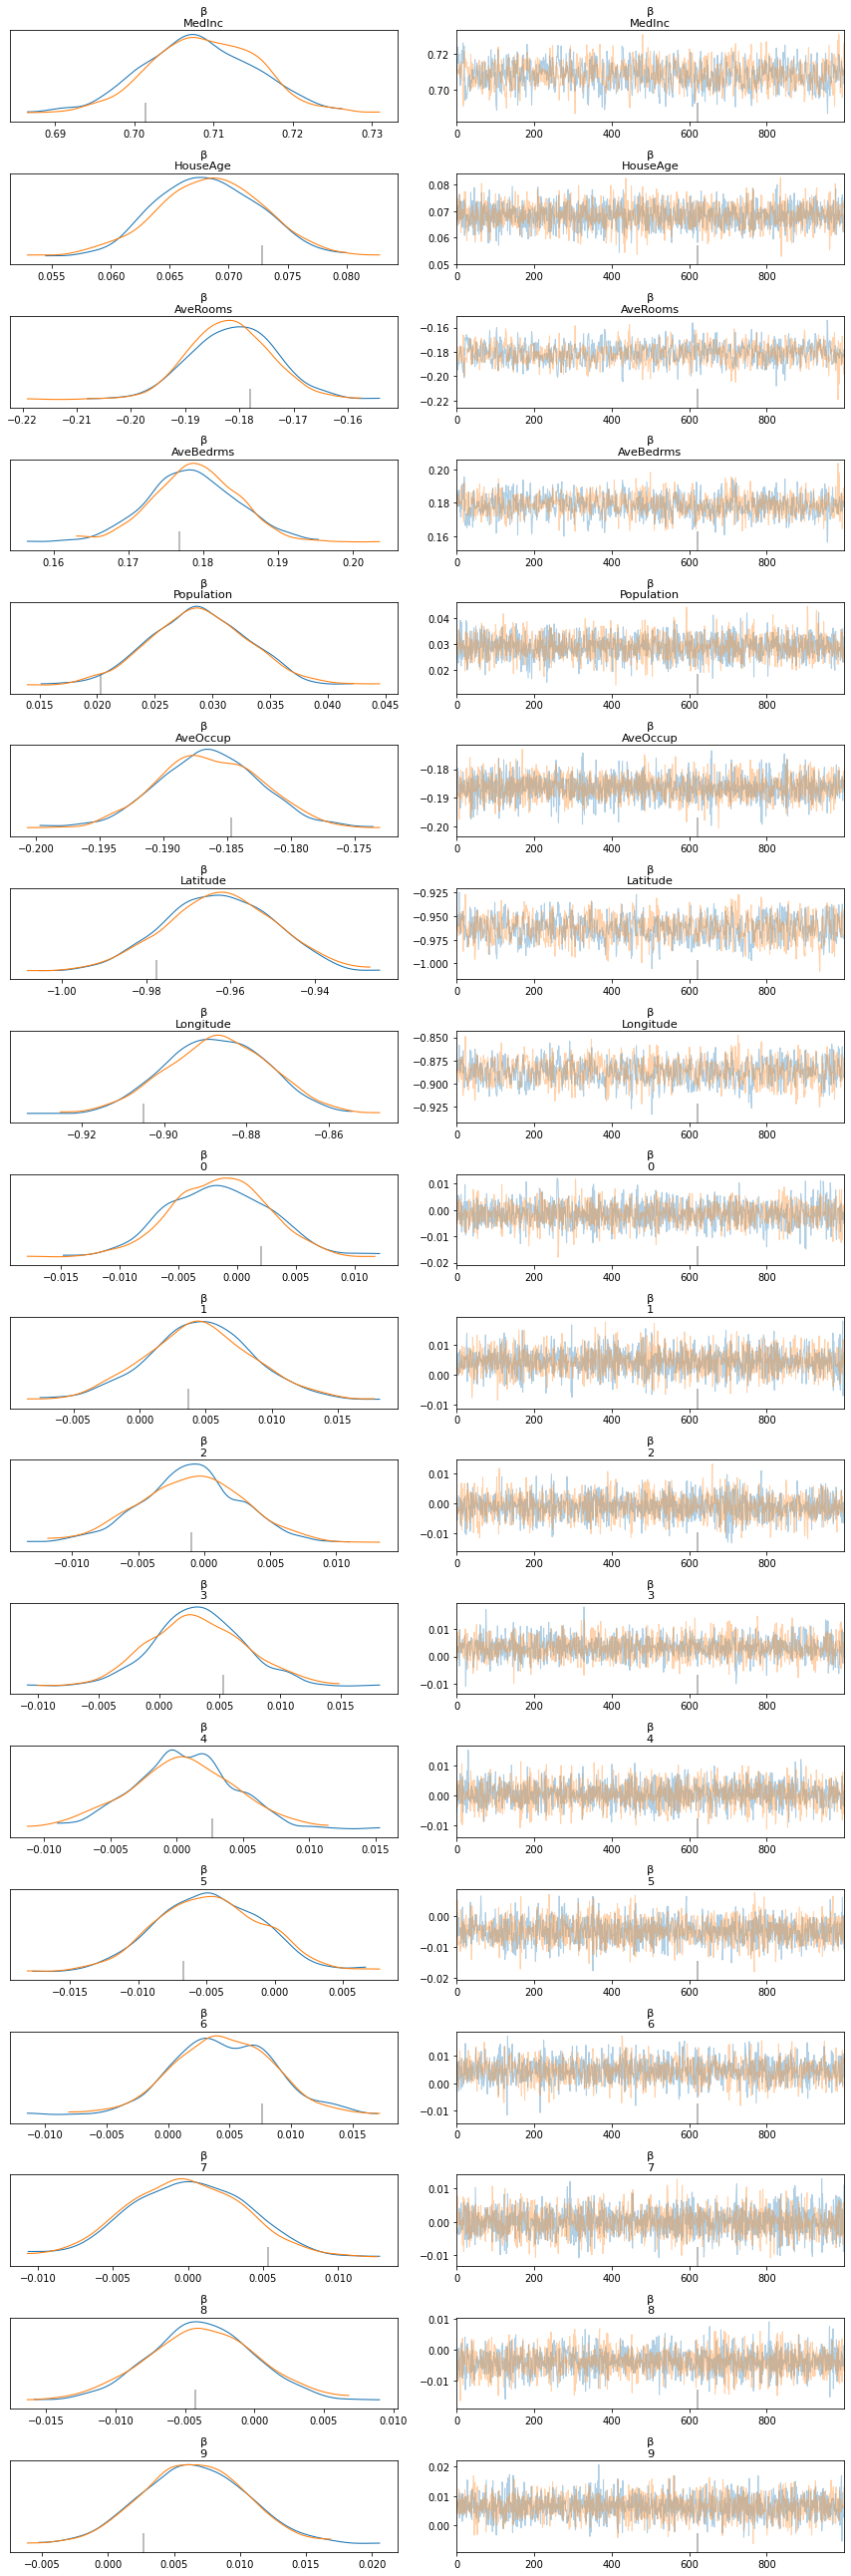

In [46]:
#!g1.1
az.plot_trace(trace, var_names=["β"], compact=False);
plt.tight_layout()

In [48]:
#!g1.1
data.columns[:-2]

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup'],
      dtype='object')

In [51]:
#!g1.1
X[:, -2:].min(), X[:, -2:].max()

(-4.0083598986462, 3.974787174091383)

In [67]:
#!g1.1
M = int(1.75 * (4 * 1.2) / 0.1)

In [68]:
#!g1.1
M

84

In [73]:
#!g1.1
with pm.Model(coords=dict(
    component=[*data.columns[:-2], *map(str, range(10)), "GP"],
    variable=[*data.columns[:-2], *map(str, range(10))],
    observation=range(X.shape[0])
)) as model_gp:
    # common 
    intercept = pm.Normal("intercept", 0, 0.05)
    σ = pm.LogNormal("σ", 0, 0.05)
    # variable and regression
    R2 = pm.Beta("R2", mu=0.6, sigma=0.2)
    ϕ = pm.Dirichlet("ϕ", [1]*6+[1]*10+[1], dims="component")
    
    model_σ = σ * R2 ** .5
    resid_σ = σ * (1 - R2) ** .5
    
    β = pm.Normal("β", 0, model_σ * ϕ[:-1] ** .5, dims="variable")
    
    μ = intercept + X[:, :-2] @ β
    
    Spatial = X[:, -2:]
    
    ls = pm.Gamma("ls", mu=1, sigma=0.5)
    cov = pm.gp.cov.ExpQuad(2, ls=ls) * (model_σ ** 2 * ϕ[-1])
    gp = pm.gp.HSGP([M, M], c=1.2, drop_first=True, cov_func=cov)
    spatial_effect = gp.prior("spatial_effect", Spatial)
    pm.Normal("obs", μ + spatial_effect, resid_σ, dims="observation", observed=Y)

In [74]:
#!g1.1
import pymc.sampling.jax

In [ ]:
#!g1.1
with model_gp:
    trace_gp = pymc.sampling.jax.sample_numpyro_nuts()

Compiling...


In [ ]:
#!g1.1
